In [ ]:
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

### DATA PREPARATION

In [ ]:
##train ,test preparation
train_data  = datasets.MNIST(root="train",train=True,transform=ToTensor(),download=True)
test_data = datasets.MNIST(root="test",train=False,download=True,transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 30923356.94it/s]


Extracting train/MNIST/raw/train-images-idx3-ubyte.gz to train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1108986.40it/s]


Extracting train/MNIST/raw/train-labels-idx1-ubyte.gz to train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12070840.32it/s]


Extracting train/MNIST/raw/t10k-images-idx3-ubyte.gz to train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6661024.04it/s]


Extracting train/MNIST/raw/t10k-labels-idx1-ubyte.gz to train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 30470316.77it/s]


Extracting test/MNIST/raw/train-images-idx3-ubyte.gz to test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1214210.33it/s]


Extracting test/MNIST/raw/train-labels-idx1-ubyte.gz to test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10132179.55it/s]


Extracting test/MNIST/raw/t10k-images-idx3-ubyte.gz to test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5903479.63it/s]

Extracting test/MNIST/raw/t10k-labels-idx1-ubyte.gz to test/MNIST/raw



In [ ]:
len(train_data.data) , len(test_data.data), len(train_data.targets),len(test_data.targets)

(60000, 10000, 60000, 10000)

In [ ]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, '6')

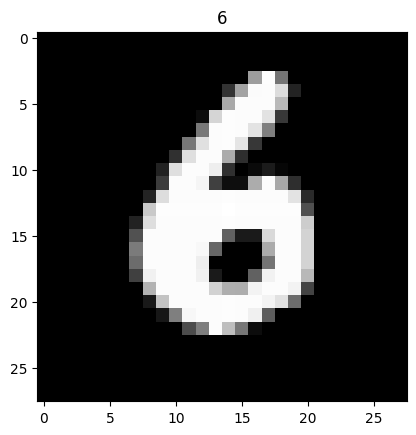

In [ ]:
### visualize the data
import torch
random = torch.randint(0,len(train_data),size=[1]).item()
image , label = train_data[random]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(label)

In [ ]:
##prepare DataLoader
BATCH_SIZE=64
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
len(train_loader) # gives the total number of batches

938

In [ ]:
## now check random random batch features as well as labels
features , batch = next(iter(train_loader))
features.shape

torch.Size([64, 1, 28, 28])

### MODEL BUILD

In [ ]:
class LENET(nn.Module):
  def __init__(self,input:int,output:int,hidden:int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input,out_channels=hidden,kernel_size=5,stride=2,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5,stride=2,padding=1)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=2),
        nn.ReLU()
    )
    self.block3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*9,out_features=output)
    )
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    return x


In [ ]:
torch.manual_seed(42)
model = LENET(input=1,output=10,hidden=16)

In [ ]:
model

LENET(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=144, out_features=10, bias=True)
  )
)

In [ ]:
x_sample = torch.randn(size=(32,1,28,28))
with torch.inference_mode():
  y_logits = model(x_sample[0])
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  print(y_pred)

tensor([2])


In [ ]:
## lets test it on random image
features , label = next(iter(train_loader))
with torch.inference_mode():
  y_logits = model(features[0])
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  print(f"The Label is ::{label[0]} for which my model predicted::{y_pred.item()}")

The Label is ::2 for which my model predicted::0


### Training loop

In [ ]:
##define optmizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)

In [ ]:
## training loop
from  tqdm.auto import tqdm
torch.manual_seed(42)
epochs = 9
acc = []
ls = []
for epoch in tqdm(range(epochs)):
  train_loss , train_Acc = 0,0
  for batch , (x,y) in enumerate(train_loader):
    model.train()
    y_logits = model(x)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    loss = loss_fn(y_logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_Acc += (y_pred==y).sum().item()/len(y_pred)
  train_loss /= len(train_loader)
  train_Acc /= len(train_loader)
  acc.append(train_Acc)
  ls.append(train_loss)
  print(f"EPOCH:{epoch} | TRAIN_LOSS:{train_loss}")

  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH:0 | TRAIN_LOSS:0.07297157187714862
EPOCH:1 | TRAIN_LOSS:0.06820496398814284
EPOCH:2 | TRAIN_LOSS:0.06819979292884179
EPOCH:3 | TRAIN_LOSS:0.07223864772312305
EPOCH:4 | TRAIN_LOSS:0.06977257169747744
EPOCH:5 | TRAIN_LOSS:0.0665578535433535
EPOCH:6 | TRAIN_LOSS:0.07152545284459844
EPOCH:7 | TRAIN_LOSS:0.07278199333181011
EPOCH:8 | TRAIN_LOSS:0.06636569212113362


### Inference to Model

In [ ]:
test_acc = 0
model.eval()
acc = []
for x,y in test_loader:
  with torch.inference_mode():
    y_logits=model(x)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    print(f"The Label is ::{y[0]} for which my model predicted::{y_pred[0]}")
    test_acc += (y_pred==y).sum().item()/len(y_pred)
    acc.append(test_acc)
  test_acc /= len(test_loader)
  print(f"The Test Accuracy is ::{test_acc}")

The Label is ::5 for which my model predicted::5
The Test Accuracy is ::0.006369426751592357
The Label is ::1 for which my model predicted::1
The Test Accuracy is ::0.006310474055742627
The Label is ::0 for which my model predicted::0
The Test Accuracy is ::0.006011531681883711
The Label is ::6 for which my model predicted::6
The Test Accuracy is ::0.006407716762304992
The Label is ::0 for which my model predicted::0
The Test Accuracy is ::0.006310717941161178
The Label is ::4 for which my model predicted::4
The Test Accuracy is ::0.006310100114274912
The Label is ::0 for which my model predicted::0
The Test Accuracy is ::0.0064096184720654455
The Label is ::2 for which my model predicted::2
The Test Accuracy is ::0.006012163174981309
The Label is ::2 for which my model predicted::2
The Test Accuracy is ::0.006009631612579499
The Label is ::5 for which my model predicted::5
The Test Accuracy is ::0.006308182366959105
The Label is ::3 for which my model predicted::3
The Test Accuracy is

### visualize prediction

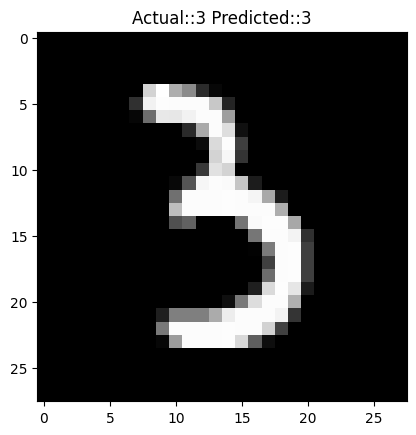

In [ ]:
x,y = next(iter(test_loader))
with torch.inference_mode():
  y_logits = model(x)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  plt.imshow(x[0].squeeze(),cmap='gray')
  plt.title(f"Actual::{y[0]} Predicted::{y_pred[0]}")

In [ ]:
acc[:5] , ls[:5]

([0.9790445095948828,
  0.9801106076759062,
  0.98042710554371,
  0.9787946428571429,
  0.980293843283582],
 [0.07297157187714862,
  0.06820496398814284,
  0.06819979292884179,
  0.07223864772312305,
  0.06977257169747744])

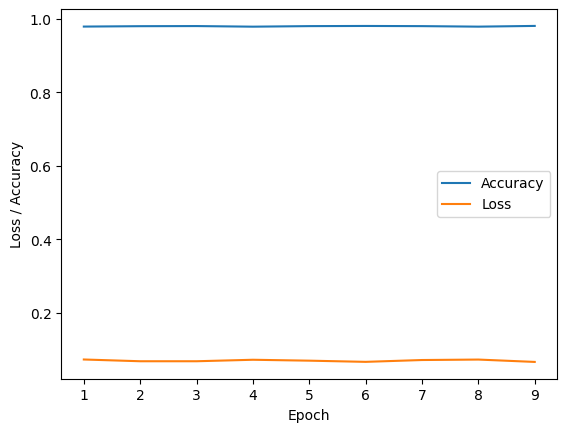

In [ ]:
fig, ax = plt.subplots()
num_epochs = len(acc)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss / Accuracy')
ax.plot(range(1, num_epochs + 1), acc, label='Accuracy')
ax.plot(range(1, num_epochs + 1), ls, label='Loss')
ax.legend()

plt.show()


In [ ]:
torch.save(model,"lenet_model.pth")

In [ ]:
torch.save(model.state_dict(),"lenet_model_state.pth")

In [ ]:
model1 = torch.load("lenet_model.pth")
model1.load_state_dict(torch.load("lenet_model_state.pth"))

<ipython-input-34-aea67e107ca5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load("lenet_model.pth")
<ipython-input-34-aea67e107ca5>:2: FutureWarning: You

<All keys matched successfully>